In [3]:
from torchvision import datasets, transforms
def build_dataset():
    train_dataset = datasets.CIFAR10(
        root="../data",                                
        train=True,
        transform=transforms.ToTensor(),
        download=True)
    test_dataset = datasets.CIFAR10(
        root="../data", 
        train=False,
        transform=transforms.ToTensor(),
        download=True)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64, 
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=64, 
        shuffle=True)
    return train_dataset, test_dataset, train_loader, test_loader

In [4]:
train_dataset = datasets.VOCDetection("../data", image_set="train", transform=transforms.ToTensor(), download=True)

0it [00:00, ?it/s]

1999642624it [08:40, 3949673.93it/s]                                

In [2]:
from torchxai.base import XaiBase, XaiHook, XaiModel

In [19]:
import torch
import matplotlib.pyplot as plt

In [14]:
a, b = train_dataset.__getitem__(0)

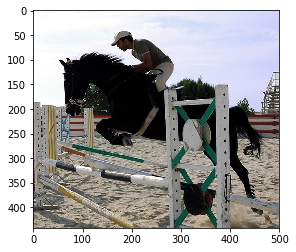

In [22]:
plt.imshow(a.permute(1, 2, 0))

In [23]:
b

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [11]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64, 
        shuffle=True)

In [39]:
import torch
import torch.nn as nn
from collections import OrderedDict

In [20]:
import sys
from pathlib import Path

sys.path.append(str(Path().absolute()))

from torchxai.base import XaiBase

In [30]:
class Cnn(XaiBase):
    def __init__(self, **kwargs):
        super(Cnn, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (B, 1, 28, 28) > (B, 32, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 24, 24) > (B, 32, 12, 12)
            nn.Conv2d(32, 64, 3),  # (B, 32, 12, 12) > (B, 64, 10, 10)
            nn.ReLU(), 
            nn.MaxPool2d(2),  # (B, 64, 10, 10) > (B, 64, 5, 5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):        
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def forward_map(self, x):
        self._reset_maps()
        for i, layer in enumerate(self.convs):
            layer_name = self._get_layer_name(layer)
            if layer_name == "relu":
                x, attns = layer(x, return_attn=True)
                self._save_maps(f"{i}"+layer_name, attns)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

---

In [10]:
import torch.nn.functional as F

class GradCAM(XaiModel):
    """GradCAM"""
    def __init__(self, model, norm_mode=1):
        """
        norm mode
        - 1 ( 0, 1) min-max normalization
        - 2 (-1, 1) min-max normalization
        - 3 mean-std normalization
        """
        super(GradCAM, self).__init__(model)
        self.norm_mode = norm_mode
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        relu_idxes = self._find_target_layer_idx(module_name="convs", layer_names=["relu"])
        self.last_relu_idx = relu_idxes["relu"][-1]
        # get Rectified Conv Features Maps
        self.f_hook = XaiHook(self.model.convs[self.last_relu_idx])
        self.b_hook = XaiHook(self.model.convs[self.last_relu_idx])
        self.register_hooks()
    
    def register_hooks(self):
        self._register_forward(self.f_hook, hook_fn=None)
        self._register_backward(self.b_hook, hook_fn=None)
    
    def reset_hooks(self):
        self.f_hook.close()
        self.b_hook.close()
    
    def cal_gradcam(self):
        # (B, C, H, W) > (B, C, 1, 1)
        alpha = self.global_avgpool(self.b_hook.i[0])
        # sum( (B, C, 1, 1) * (B, C, H, W) , dim=1) > (B, 1, H, W)
        gradcam = torch.relu((alpha * self.f_hook.o).sum(1, keepdim=True))
        return gradcam
        
    def post_processing(self, gradcam, H, W):
        """
        interpolate(up sample) & normalize
        https://pytorch.org/docs/stable/nn.functional.html#interpolate
        """
        gradcam = F.interpolate(gradcam, size=(H, W), mode="bilinear", align_corners=False)
        gradcam = self.normalization(gradcam)
        return gradcam
    
    def normalization(self, tensor):
        B, C, H, W = tensor.size()
        tensor = tensor.view(B, -1)
        t_min = tensor.min(dim=1, keepdim=True)[0]
        t_max = tensor.max(dim=1, keepdim=True)[0]
        t_mean = tensor.mean(dim=1, keepdim=True)
        t_std = tensor.std(dim=1, keepdim=True)
        if self.norm_mode == 1:
            tensor -= t_min
            tensor /= (t_max - t_min + 1e-10)
        elif self.norm_mode == 2:
            tensor -= t_min
            tensor *= 2
            tensor /= (t_max - t_min + 1e-10)
        elif self.norm_mode == 3:
            tensor -= t_mean
            tensor /= t_std
        return tensor.view(B, C, H, W)
        
    def get_attribution(self, x, targets):
        *_, H, W = x.size()
        self.model.zero_grad()
        
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        
        gradcam = self.cal_gradcam()
        gradcam = self.post_processing(gradcam, H, W)
        
        return gradcam.detach()

In [11]:
import matplotlib.pyplot as plt

gradcam_model = GradCAM(model)
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])
gradcam = gradcam_model.get_attribution(x, targets)
plt.imshow(gradcam.squeeze())
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:
class GuidedBackprop(XaiModel):
    """GuidedBackprop"""
    def __init__(self, model):
        super(GuidedBackprop, self).__init__(model)
        self.register_guided_hooks(self.model.convs)
    
    def reset_f_outputs(self):
        self.f_outputs = []
    
    def register_guided_hooks(self, layers):
        self.relu_f_hooks = []
        self.relu_b_hooks = []
        self.reset_f_outputs()
        for layer in layers:
            layer_name = type(layer).__name__
            if layer_name.lower() == "relu":
                f_hook = XaiHook(layer)
                b_hook = XaiHook(layer)
                self.relu_f_hooks.append(f_hook)
                self.relu_b_hooks.append(b_hook)
                
        def guided_forward(m, i, o):
            self.f_outputs.append(o.data)  
            
        def guided_backward(m, i, o):
            deconv_grad = o[0].clamp(min=0)  # o: backward input
            forward_output = self.f_outputs.pop(-1)
            forward_mask = forward_output.ne(0.0).type_as(forward_output)
            grad_in = deconv_grad * forward_mask
            return (grad_in, )
        
        # register forward hooks
        self._register_forward(self.relu_f_hooks, hook_fn=guided_forward)
        self._register_backward(self.relu_b_hooks, hook_fn=guided_backward)
        
    def get_attribution(self, x, targets):
        x.requires_grad_(True)
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(False)
        return x_grad

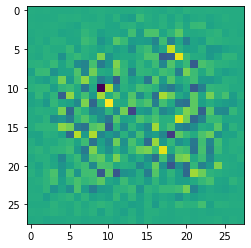

In [13]:
guided_model = GuidedBackprop(model)
grad = guided_model.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

In [14]:
class VanillaGrad(XaiModel):
    """VanillaGrad"""
    def __init__(self, model):
        super(VanillaGrad, self).__init__(model)
        
    def get_attribution(self, x, target):
        """vanilla gradient"""
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(requires_grad=False)
        return x_grad

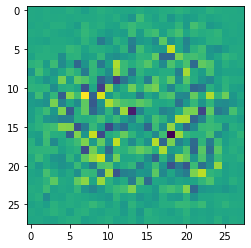

In [15]:
vanillagrad = VanillaGrad(model)
grad = vanillagrad.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

In [16]:
class GradInput(XaiModel):
    """GradInput"""
    def __init__(self, model):
        super(GradInput, self).__init__(model)
        
    def get_attribution(self, x, target):
        """vanilla gradient*input"""
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(requires_grad=False)
        
        return x_grad * x.data

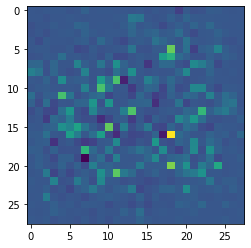

In [17]:
gradinput = GradInput(model)
grad = gradinput.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

In [18]:
class DeconvNet(XaiModel):
    """DeconvNet"""
    def __init__(self, model, module_name="convs"):
        super(DeconvNet, self).__init__(model)
        layer_names = ["conv2d", "maxpool2d"]
        self.module_name = module_name
        self.deconvs_indices = self.find_idxes(module_name, layer_names)
        self.layers = self.make_layers(module_name)
        self.init_weights(module_name, layer_name="conv2d")
        
    def find_idxes(self, module_name, layer_names):
        """
        args:
        - module_name
        - layer_names: 
        
        return:
        get `deconvs_indices` for the `module_name`, 
        - key: decovnet layer name 
        - values: indices dict match to {convnet:decovnet}
        """
        convs_indices = self._find_target_layer_idx(module_name, layer_names)
        last_layer_num = len(self.model._modules[module_name]) - 1
        deconvs_indices = defaultdict(dict)
        
        for l_name in layer_names:
            idxes = (last_layer_num - torch.LongTensor(convs_indices[l_name])).tolist()
            deconvs_indices[l_name] = dict(zip(convs_indices[l_name], idxes))
            if l_name == "conv2d":
                deconvs_indices[l_name+"-bias"] = dict(zip(
                    convs_indices[l_name], idxes[1:]+[None]))
            
        return deconvs_indices
    
    def make_layers(self, module_name):
        """
        maxunpool > relu > conv 
        """
        layers = []
        modules = self.model._modules[module_name]
        for layer in modules:
            if isinstance(layer, nn.Conv2d):
                temp_layer = nn.ConvTranspose2d(layer.out_channels,
                                                layer.in_channels,
                                                layer.kernel_size, 
                                                layer.stride, 
                                                layer.padding,
                                                layer.output_padding,
                                                layer.groups, 
                                                False,  # bias
                                                layer.dilation,
                                                layer.padding_mode)
                layers.append(temp_layer)
            elif isinstance(layer, nn.MaxPool2d):
                temp_layer = nn.MaxUnpool2d(layer.kernel_size,
                                            layer.stride,
                                            layer.padding)
                layers.append(temp_layer)
            else:
                layers.append(layer)
        return nn.Sequential(*reversed(layers))
    
    def init_weights(self, module_name, layer_name):
        convs = self.model._modules[module_name]
        conv_indices = self.deconvs_indices[layer_name]
        conv_bias_indices = self.deconvs_indices[layer_name+"-bias"]
        for i, layer in enumerate(convs):
            if type(layer).__name__.lower() == layer_name:
                # ex: 3 conv layers (conv, relu, maxpool)
                # 'conv2d': {0: 8, 3: 5, 6: 2}
                # 'conv2d-bias': {0: 5, 3: 2, 6: None}
                
                deconv_idx = conv_indices.get(i)
                weight = convs[i].weight.data
                self.layers[deconv_idx].weight.data = weight
                
                deconv_bias_idx = conv_bias_indices.get(i)
                if deconv_bias_idx is not None:
                    bias = convs[i].bias
                    self.layers[deconv_bias_idx].bias = bias
                
                            
    def get_attribution(self, x, targets):
        unpool_locations = self.deconvs_indices["maxpool2d"]
        unpool_locations = {v: k for k, v in unpool_locations.items()}
        convs = self.model._modules[self.module_name]

        switches = OrderedDict()
        self._reset_maps()
        self._return_indices(convs, on=True)
        for i, layer in enumerate(convs):
            if isinstance(layer, nn.MaxPool2d):
                x, switch = layer(x)
                switches[i] = switch
            else:
                x = layer(x)
                
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.MaxUnpool2d):
                j = unpool_locations[i]
                x = layer(x, switches[j])
            elif isinstance(layer, nn.ConvTranspose2d):
                x = layer(x)
                layer_name = type(layer).__name__.lower() + f"-{i}"
                self._save_maps(layer_name, x.data)
            else:
                x = layer(x)
        self._return_indices(convs, on=False)
        x_ret = x.clone().detach().data
        return x_ret

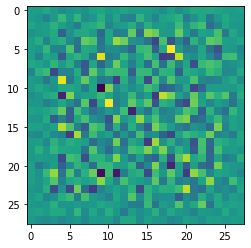

In [19]:
deconvnet = DeconvNet(model)
deconv = deconvnet.get_attribution(x, targets)
plt.imshow(deconv.squeeze())
plt.show()

In [242]:
class relLinear(XaiHook):
    """relLinear"""
    def __init__(self, module, use_rho=False):
        """
        forward
        > input: (B, in_f)
        > output: (B, out_f)
        backward
        > lrp propagation with respect to previous input
        """
        super(relLinear, self).__init__(module)
        self.out_features = self.module.out_features
        self.use_rho = use_rho
        self.register_hook(backward=False, hook_fn=self.f_hook)
        self.register_hook(backward=True, hook_fn=self.b_hook)
    
    def f_hook(self, m, i, o):
        """
        forward hook
        i: (input,)
        o: output
        
        save forward input and output data
        """
        self.input = i[0].clone().data
        self.output = o.clone().data
    
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (grad_bias, grad_input, grad_weight.T) -> backward output
        o: (gard_output,) -> backward input
        
        ### implementation method 1
        [Step 1]: (B, in_f, 1) * (1, in_f, out_f) = (B, in_f, out_f)
        [Step 2]: (B, 1, out_f), do not multiply `torch.sign(self.output.unsqueeze(1))` 
                  that returns `nan` in tensor
        [Step 3]: divide by s
        [Step 4]: (B, in_f, out_f) x (B, out_f, 1) = (B, in_f)
        
        ```
        # Step 1
        z = self.input.unsqueeze(-1) * w.transpose(0, 1).unsqueeze(0)
        # Step 2
        s = self.output.unsqueeze(1) + eps * torch.sign(self.output.unsqueeze(1))  
        # Step 3
        weight = z / s
        # Step 4
        r_next = torch.bmm(weight, r.unsqueeze(-1)).squeeze()
        ```
        ### implemetation method 2
        # Step 1: (B, out_f), do not multiply `torch.sign(self.output)` that returns `nan` in tensor
        # Step 2: (B, out_f) / (B, out_f) = (B, out_f)
        # Step 3: (B, in_f, out_f) * (B, out_f, 1) = (B, in_f)
        # Step 4: (B, in_f) x (B, in_f) = (B, in_f)
        
        ```
        # Step 1
        s = self.output + eps
        # Step 2
        e = r / s
        # Step 3
        c = torch.bmm(w.transpose(0, 1).expand(e.size(0), 
                                               self.module.in_features, 
                                               self.module.out_features), 
                      e.unsqueeze(-1)).squeeze(-1)
        # Step 4
        r_next = self.input * c
        ```
        """
        grad_bias, grad_in, grad_weight = i
        r = o[0]
        eps = 1e-6
        w = self.rho(self.module.weight)
        # Step 1
        s = self.output + eps
        # Step 2
        e = r / s
        # Step 3
        c = torch.bmm(w.transpose(0, 1).expand(e.size(0), 
                                               self.module.in_features, 
                                               self.module.out_features), 
                      e.unsqueeze(-1)).squeeze(-1)
        # Step 4
        r_next = self.input * c
        assert r_next.size(1) == self.module.in_features, "size of `r_next` is not correct"
        # for debugging
        self.r = r  
        self.r_next = r_next
        return (grad_bias, r_next, grad_weight)
        
    def rho(self, w):
        if self.use_rho:
            return torch.clamp(w, min=0)
        else:
            return w

In [243]:
class relReLU(XaiHook):
    """relReLU"""
    def __init__(self, module):
        super(relReLU, self).__init__(module)
        self.register_hook(backward=True, hook_fn=self.b_hook)
        
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (input,) -> backward output
        o: (output,) -> backward input
        """
        r = o
        return r

In [244]:
class relConv2d(XaiHook):
    """relConv2d"""
    def __init__(self, module, use_rho=False):
        """
        forward
        > input: (B, C_in, H_in, W_in)
        > output: (B, C_out, H_out, W_out)
        backward
        > lrp propagation with respect to previous input
        """
        super(relConv2d, self).__init__(module)
        self.use_rho = use_rho
        self.register_hook(backward=False, hook_fn=self.f_hook)
        self.register_hook(backward=True, hook_fn=self.b_hook)
    
    def f_hook(self, m, i, o):
        """
        forward hook
        i: (input,)
        o: output
        
        save forward input and output data
        """
        self.input = i[0].clone().data
        self.output = o.clone().data
    
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (grad_input, grad_weight, gard_bias) -> backward output
        o: (gard_output,) -> backward input
        
        ### implementation method 
        [Step 1]: (B, C_out, H_out, W_out), do not multiply `torch.sign(self.output)` 
                   that returns `nan` in tensor
        [Step 2]: (B, C_out, H_out, W_out) / (B, C_out, H_out, W_out) = (B, C_out, H_out, W_out)
        [Step 3]: (B, C_out, H_out, W_out) --> (B, C_in, H, W)
                  same as `self.gradprop(s*e)` or `(s*e).backward(); c=self.input.grad`
        [Stpe 4]: (B, C_in, H, W) x (B, C_in, H, W) = (B, C_in, H, W)
        
        ```
        # Step 1
        s = self.output + eps 
        # Step 2
        e = r / s
        # Step 3:
        c = self.gradprop(e, w)
        # Step 4
        r_next = self.input * c
        ```
        """
        _, grad_weight, grad_bias = i
        r = o[0]
        eps = 1e-6
        w = self.rho(self.module.weight)
        # Step 1
        s = self.output + eps 
        # Step 2
        e = r / s
        # Step 3:
        c = self.gradprop(e, w)
        # Step 4
        r_next = self.input * c

        # for debugging
        # self.r = r  
        # self.r_next = r_next
        return (r_next, grad_weight, grad_bias)
#         return r_next
        
    def rho(self, w):
        if self.use_rho:
            return torch.clamp(w, min=0)
        else:
            return w

    def gradprop(self, x, w):
        """
        `ConvTransposed2d` can be seen as the gradient of `Conv2d` with respect to its input.
        """
        output_padding = self.cal_output_padding()
        c = torch.nn.functional.conv_transpose2d(x, 
                                                 weight=w, 
                                                 stride=self.module.stride, 
                                                 padding=self.module.padding, 
                                                 output_padding=output_padding)
        return c        

    def cal_output_padding(self):
        """
        calculate output_padding size
        - size of height or width: (X_in + 2P - K) / S + 1 = X_out
        - output_padding = X_in - ((X_out - 1) * S + K - 2P)

        * what is output_padding?
        from PyTorch Document:
        https://pytorch.org/docs/stable/nn.html#convtranspose2d

        The padding argument effectively adds `dilation * (kernel_size - 1) - padding` amount of zero padding to 
        both sizes of the input. This is set so that when a `Conv2d` and a `ConvTranspose2d` are initialized with 
        same parameters, they are inverses of each other in regard to the input and output shapes. 
        However, when `stride > 1`, `Conv2d` maps multiple input shapes to the same output shape. 
        `output_padding` is provided to resolve this ambiguity by effectively increasing 
        the calculated output shape on one side. Note that output_padding is only used to find output shape, 
        but does not actually add zero-padding to output.
        """
        H_in, W_in = self.input.size()[2:]
        H_out, W_out = self.output.size()[2:]
        S_h, S_w = self.module.stride
        K_h, K_w = self.module.kernel_size
        P_h, P_w = self.module.padding
        H_output_padding = H_in - ((H_out - 1)*S_h + K_h - 2*P_h)
        W_output_padding = W_in - ((W_out - 1)*S_w + K_w - 2*P_w)
        return (H_output_padding, W_output_padding)

In [245]:
class relMaxPool2d(XaiHook):
    """relMaxPool2d"""
    def __init__(self, module, use_rho=False):
        """
        forward
        > input: (B, C, H_in, W_in)
        > output: (B, C, H_out, W_out)
        backward
        > lrp propagation with respect to previous input
        """
        super(relMaxPool2d, self).__init__(module)
        self.use_rho = use_rho
        self.register_hook(backward=False, hook_fn=self.f_hook)
        self.register_hook(backward=True, hook_fn=self.b_hook)
    
    def f_hook(self, m, i, o):
        """
        forward hook
        i: (input,)
        o: output
        
        save forward input and output data
        """
        self.input = i[0].clone().data
        self.output = o.clone().data
        
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (grad_input,) -> backward output
        o: (gard_output,) -> backward input
        
        ### implementation method 
        [Step 1]: (B, C, H_out, W_out), do not multiply `torch.sign(self.output)` 
                  that returns `nan` in tensor
        [Step 2]: (B, C, H_out, W_out) / (B, C, H_out, W_out) = (B, C, H_out, W_out)
        [Step 3]: (B, C, H_out, W_out) --> (B, C, H_in, W_in)
                  same as `self.gradprop(s*e)` or `(s*e).backward(); c=self.input.grad`
        [Stpe 4]: (B, C, H_in, W_in) x (B, C, H_in, W_in) = (B, C, H_in, W_in)
        
        ```
        # Step 1
        s = self.output + eps 
        # Step 2
        e = r / s
        # Step 3:
        c = self.gradprop(e)
        # Step 4
        r_next = self.input * c
        ```
        """        
        r = o[0]
        eps = 1e-6
        # Step 1
        s = self.output + eps
        # Step 2
        e = r / s
        # Step 3
        c = self.gradprop(e)
        # Step 4
        r_next = self.input * c
        
        # for debugging
        # self.r = r  
        # self.r_next = r_next
        return (r_next,)
#         return r_next
    
    def gradprop(self, x):
        """
        get maxpooled switches first then unpool
        """
        _, switches = torch.nn.functional.max_pool2d(self.input, 
                                                     self.module.kernel_size, 
                                                     self.module.stride, 
                                                     self.module.padding, 
                                                     self.module.dilation, 
                                                     self.module.ceil_mode, 
                                                     return_indices=True)
        c = torch.nn.functional.max_unpool2d(x, switches, 
                                             self.module.kernel_size, 
                                             self.module.stride, 
                                             self.module.padding)
        return c

In [246]:
class LRP(XaiModel):
    """LRP"""
    def __init__(self, model, use_rho=False):
        """
        module_names: have to be sequential to forward network 
        """
        super(LRP, self).__init__(model)
        self.module_names = module_names
        self.use_rho = use_rho
        self.available_module = {
            nn.Linear: relLinear, 
            nn.Conv2d: relConv2d, 
            nn.MaxPool2d: relMaxPool2d, 
            nn.ReLU: relReLU
        }
        self.create_layers()
        
    def create_layers(self):
        for name, modules in self.model._modules.items():
            if isinstance(modules, nn.Sequential):
                for i, layer in enumerate(modules):
                    try:
                        modules[i] = self._create_layer(layer)
                    except KeyError as e:
                        print(f"{type(layer)} is not an available module.\nAvaiable:")
                        for k in self.available_module.keys():
                            print(f" - {k}")
            else:
                modules = self._create_layer(layer)      
    
    def forward(self, x):
        return self.model(x)
    
    def _create_layer(self, layer):
        if isinstance(layer, nn.ReLU):
            return self.available_module[type(layer)](layer)
        else:
            return self.available_module[type(layer)](layer, use_rho=self.use_rho)

    def get_attribution(self, x, targets):
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.forward(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(requires_grad=False)
        return x_grad

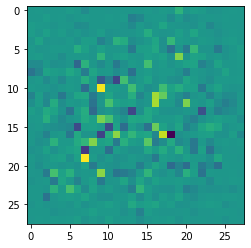

In [247]:
lrp_model = LRP(model)
lrp = lrp_model.get_attribution(x, targets)
plt.imshow(lrp.squeeze())
plt.show()